In [1]:
import numpy as np
import scipy
import pandas as pd
import math
import random
import sklearn
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
mpl.style.use('seaborn')

## 1. Data separation and cleansing

In [2]:
df= pd.read_csv("/Users/luyin/Desktop/SP 18/train_ver2.csv",
                    usecols=['ncodpers','fecha_dato','ind_nuevo','ind_ahor_fin_ult1', 'ind_aval_fin_ult1', 
                             'ind_cco_fin_ult1', 'ind_cder_fin_ult1',
                             'ind_cno_fin_ult1', 'ind_ctju_fin_ult1',
                             'ind_ctma_fin_ult1', 'ind_ctop_fin_ult1',
                             'ind_ctpp_fin_ult1', 'ind_deco_fin_ult1',
                             'ind_deme_fin_ult1', 'ind_dela_fin_ult1',
                             'ind_ecue_fin_ult1', 'ind_fond_fin_ult1',
                             'ind_hip_fin_ult1', 'ind_plan_fin_ult1',
                             'ind_pres_fin_ult1', 'ind_reca_fin_ult1',
                             'ind_tjcr_fin_ult1', 'ind_valo_fin_ult1',
                             'ind_viv_fin_ult1', 'ind_nomina_ult1',
                             'ind_nom_pens_ult1', 'ind_recibo_ult1'])

Recommender systems have a problem known as user cold-start, in which is hard do provide personalized recommendations for users with none or a very few number of consumed items, due to the lack of information to model their preferences.
For this reason, we are keeping in the dataset only customers with that are not new customers as our first filter. 

In [3]:
df= df[df['ind_nuevo'] == 0] # see only old customers

In [4]:
df['fecha_dato'] = pd.to_datetime(df['fecha_dato'], format='%Y-%m-%d', errors='coerce')
df['fecha_dato'].unique()

array(['2015-01-28T00:00:00.000000000', '2015-02-28T00:00:00.000000000',
       '2015-03-28T00:00:00.000000000', '2015-04-28T00:00:00.000000000',
       '2015-05-28T00:00:00.000000000', '2015-06-28T00:00:00.000000000',
       '2015-07-28T00:00:00.000000000', '2015-08-28T00:00:00.000000000',
       '2015-09-28T00:00:00.000000000', '2015-10-28T00:00:00.000000000',
       '2015-11-28T00:00:00.000000000', '2015-12-28T00:00:00.000000000',
       '2016-01-28T00:00:00.000000000', '2016-02-28T00:00:00.000000000',
       '2016-03-28T00:00:00.000000000', '2016-04-28T00:00:00.000000000',
       '2016-05-28T00:00:00.000000000'], dtype='datetime64[ns]')

In [31]:
date_list = list(df['fecha_dato'].unique())
df_train = df[df.fecha_dato.isin(date_list[0:16])] # from 2015-01-28 to 2016-04-28
df_test = df.loc[df.fecha_dato==date_list[-1]] # choose the last month as test data
df_remove = df[df.fecha_dato.isin(date_list[15:16])] # the df_remove should be carefully choosen
df_test0 = df_remove[:100]
df_remove.head()

,fecha_dato,ncodpers,ind_nuevo,ind_ahor_fin_ult1,ind_aval_fin_ult1,ind_cco_fin_ult1,ind_cder_fin_ult1,ind_cno_fin_ult1,ind_ctju_fin_ult1,ind_ctma_fin_ult1,...,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1
11787582,2016-04-28,896836,0.0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0.0,0.0,0
11787583,2016-04-28,896837,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,0
11787584,2016-04-28,896839,0.0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0.0,0.0,0
11787585,2016-04-28,896853,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,0
11787586,2016-04-28,896849,0.0,0,0,0,0,1,0,1,...,0,0,0,0,1,0,0,0.0,0.0,0


In [6]:
df_customer1 = df_train.drop(['ind_nuevo','fecha_dato'], axis = 1) #drop dates and new customers indicator.
df_product = df_train.drop(['ncodpers','ind_nuevo','fecha_dato'], axis = 1)

In [7]:
df_customer1.head()

,ncodpers,ind_ahor_fin_ult1,ind_aval_fin_ult1,ind_cco_fin_ult1,ind_cder_fin_ult1,ind_cno_fin_ult1,ind_ctju_fin_ult1,ind_ctma_fin_ult1,ind_ctop_fin_ult1,ind_ctpp_fin_ult1,...,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1
0,1375586,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,0
1,1050611,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,0
2,1050612,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,0
3,1050613,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,0
4,1050614,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,0


## 2. Traditional recommendation models

### 2.1 Popularity Recommender

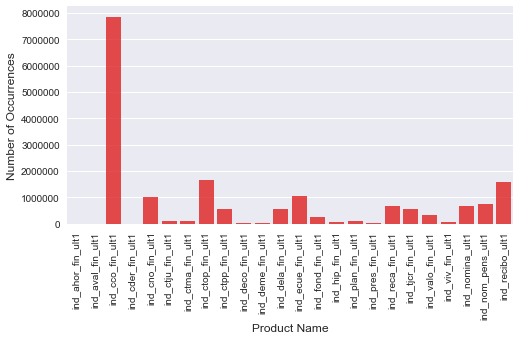

In [8]:
# popularity_recommend = sorted(target_counts, key=lambda x: x[1], reverse=True)
# pop_scores = list(target_counts)
target_counts = df_product.astype('float64').sum(axis=0)
plt.figure(figsize=(8,4))
sns.barplot(target_counts.index, target_counts.values, alpha=0.8, color='red')
plt.xlabel('Product Name', fontsize=12)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()
df_target = pd.DataFrame(target_counts, columns=['counts'])

In [9]:
# df_target.sort_values(by = ['counts'])
df_sort = df_target.reset_index()
df_sort = df_sort.sort_values(by = ['counts'], ascending=False)

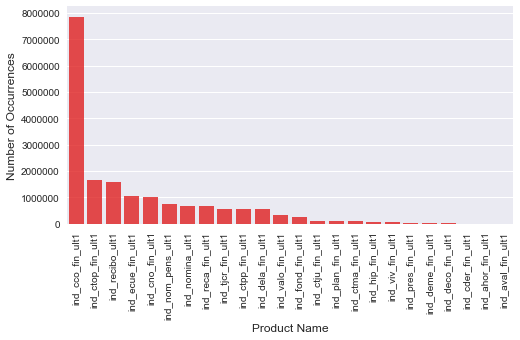

In [10]:
plt.figure(figsize=(8,4))
sns.barplot(df_sort['index'], df_sort['counts'], alpha=0.8, color='red')
plt.xlabel('Product Name', fontsize=12)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

In [11]:
df_sort.head(7)

,index,counts
2,ind_cco_fin_ult1,7857455.0
7,ind_ctop_fin_ult1,1658774.0
23,ind_recibo_ult1,1589246.0
12,ind_ecue_fin_ult1,1040211.0
4,ind_cno_fin_ult1,1007626.0
22,ind_nom_pens_ult1,740469.0
21,ind_nomina_ult1,681661.0


### 2.2 Similarity Recommender with TF-IDF transformation

In [12]:
#TF
TF = df_customer1.groupby(['ncodpers'],as_index = False, sort = False).sum().rename(columns = {'ncodpers': 'customer_id'})
TF_ind = TF.set_index('customer_id')
TF_items = TF.drop(['customer_id'], axis = 1) # TF calculation 
TF_items.head()

,ind_ahor_fin_ult1,ind_aval_fin_ult1,ind_cco_fin_ult1,ind_cder_fin_ult1,ind_cno_fin_ult1,ind_ctju_fin_ult1,ind_ctma_fin_ult1,ind_ctop_fin_ult1,ind_ctpp_fin_ult1,ind_deco_fin_ult1,...,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1
0,0,0,16,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,3
1,0,0,16,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,0
2,0,0,16,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,0
3,0,0,0,0,0,0,0,0,0,2,...,0,0,0,0,0,0,0,0.0,0.0,0
4,0,0,16,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,0


In [13]:
TF_customer = pd.DataFrame(TF['customer_id'])
user_id = TF_customer[:10000] #Get user id

In [14]:
#IDF
DF_items = TF_ind.copy()
DF_items.shape[0] #the total amount of unique users

891331

In [15]:
DF_items[DF_items > 0] = 1 #Unique count of the items' frequency
DF_counts = DF_items.sum(axis=0)
DF_counts.head(24)

ind_ahor_fin_ult1        89.0
ind_aval_fin_ult1        23.0
ind_cco_fin_ult1     578423.0
ind_cder_fin_ult1       402.0
ind_cno_fin_ult1      80947.0
ind_ctju_fin_ult1      8254.0
ind_ctma_fin_ult1      9984.0
ind_ctop_fin_ult1    107563.0
ind_ctpp_fin_ult1     36982.0
ind_deco_fin_ult1      2162.0
ind_deme_fin_ult1      1846.0
ind_dela_fin_ult1     46790.0
ind_ecue_fin_ult1     76902.0
ind_fond_fin_ult1     17182.0
ind_hip_fin_ult1       5027.0
ind_plan_fin_ult1      7991.0
ind_pres_fin_ult1      2178.0
ind_reca_fin_ult1     45299.0
ind_tjcr_fin_ult1     57658.0
ind_valo_fin_ult1     23801.0
ind_viv_fin_ult1       3253.0
ind_nomina_ult1       65892.0
ind_nom_pens_ult1     70784.0
ind_recibo_ult1      147609.0
dtype: float64

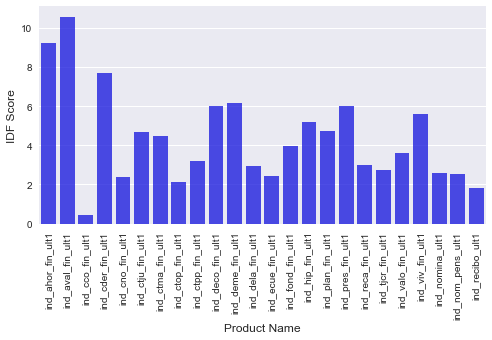

In [16]:
IDF = np.log(DF_items.shape[0]/(DF_counts)) # this is the log of inverse DF, in case the DF_counts
plt.figure(figsize=(8,4))
sns.barplot(IDF.index, IDF.values, alpha=0.8, color='blue')
plt.xlabel('Product Name', fontsize=12)
plt.ylabel('IDF Score', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

In [17]:
TF_IDF = TF_items * IDF # Calculate TF-IDF score
TF_IDF.head()

,ind_ahor_fin_ult1,ind_aval_fin_ult1,ind_cco_fin_ult1,ind_cder_fin_ult1,ind_cno_fin_ult1,ind_ctju_fin_ult1,ind_ctma_fin_ult1,ind_ctop_fin_ult1,ind_ctpp_fin_ult1,ind_deco_fin_ult1,...,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1
0,0.0,0.0,6.918567,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.394447
1,0.0,0.0,6.918567,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,0.0,0.0,6.918567,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,12.043364,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,0.0,0.0,6.918567,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000



### Sampling on the first 10000 users

In [18]:
sample = TF_IDF[:10000]
sample.head(5)

,ind_ahor_fin_ult1,ind_aval_fin_ult1,ind_cco_fin_ult1,ind_cder_fin_ult1,ind_cno_fin_ult1,ind_ctju_fin_ult1,ind_ctma_fin_ult1,ind_ctop_fin_ult1,ind_ctpp_fin_ult1,ind_deco_fin_ult1,...,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1
0,0.0,0.0,6.918567,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.394447
1,0.0,0.0,6.918567,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,0.0,0.0,6.918567,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,12.043364,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,0.0,0.0,6.918567,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


### Similarity Calculation Based on TF-IDF

In [19]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse
import time

start = time.time()

A_sparse = sparse.csr_matrix(sample)
similarities = cosine_similarity(A_sparse)
print('pairwise similarity output:\n {}\n'.format(similarities))
print(similarities.shape)
print('\n')

end = time.time()
print("--- %s seconds ---" % (end - start))

pairwise similarity output:
 [[1.         0.78861479 0.78861479 ... 0.78861479 0.78861479 0.78861479]
 [0.78861479 1.         1.         ... 1.         1.         1.        ]
 [0.78861479 1.         1.         ... 1.         1.         1.        ]
 ...
 [0.78861479 1.         1.         ... 1.         1.         1.        ]
 [0.78861479 1.         1.         ... 1.         1.         1.        ]
 [0.78861479 1.         1.         ... 1.         1.         1.        ]]

(10000, 10000)


--- 5.525560140609741 seconds ---


We change the diagonal to 0 to remove user itself from simialr userss

In [20]:
similarities[np.diag_indices_from(similarities)] = 0 #it is important to change diagonal to 0 to screen out user itself
print('pairwise dense output:\n {}\n'.format(similarities))

pairwise dense output:
 [[0.         0.78861479 0.78861479 ... 0.78861479 0.78861479 0.78861479]
 [0.78861479 0.         1.         ... 1.         1.         1.        ]
 [0.78861479 1.         0.         ... 1.         1.         1.        ]
 ...
 [0.78861479 1.         1.         ... 0.         1.         1.        ]
 [0.78861479 1.         1.         ... 1.         0.         1.        ]
 [0.78861479 1.         1.         ... 1.         1.         0.        ]]



In [21]:
sim = pd.DataFrame(similarities)
sim['customer_id'] = user_id
sim.head()

,0,1,2,3,4,5,6,7,8,9,...,9991,9992,9993,9994,9995,9996,9997,9998,9999,customer_id
0,0.000000,0.788615,0.788615,0.0,0.788615,0.788615,0.788615,0.788615,0.788615,0.716625,...,0.788615,0.788615,0.788615,0.788615,0.788615,0.788615,0.788615,0.788615,0.788615,1375586
1,0.788615,0.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,0.908714,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1050611
2,0.788615,1.000000,0.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,0.908714,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1050612
3,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1050613
4,0.788615,1.000000,1.000000,0.0,0.000000,1.000000,1.000000,1.000000,1.000000,0.908714,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1050614


In [22]:
# sim_id = sim.set_index('customer_id')
# sim_id.head()

### Get Top Similiar Users

In [23]:
indices = pd.Series(sim.index, index=sim['customer_id']).drop_duplicates() #get index of users

def get_similar_users(user_id, top, cosine_sim=similarities):
    u_idx = indices[user_id] #index of primary users
    sim_scores = list(enumerate(cosine_sim[u_idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True) #the output is a sorted list of similar users
    sim_scores = sim_scores[1:(top+1)]
    similar_user_indices = [i[0] for i in sim_scores]
    return u_idx, sim['customer_id'].iloc[similar_user_indices], user_id


In [103]:
top_1 = 7

def get_recommendations(similar_user, score_df, remove, top_1=top_1):
    output = []
    primary_user_idx = similar_user[0]
    df_recm = similar_user[1]
    df_recm = pd.DataFrame(df_recm).reset_index() #reset similar user index
    user_id = similar_user[2] #get primary user id
    product_idx = pd.DataFrame(score_df.columns, columns = ['product_name']) # Get product index
    user_idx = list(df_recm.iloc[:,0]) # get user index as a list
    
    #Generate remove list
    previous_user_list = []
    if user_id in list(remove['ncodpers']):
        r = remove[remove['ncodpers'] == user_id] #get remove items associated with this user id
        for items in r.columns:
            b = r[items].item() 
            if b == 1:
                previous_user_list.append(items) #get the remove list
    
    #Get items from similari users
    for i in user_idx:
        l_1 =score_df.iloc[i]>0
        for index, x in enumerate(l_1):
            if x == True:
                item = product_idx['product_name'][index]
                if (item not in output) and (item not in previous_user_list): #remove items from the list
                    output.append(item)
                    
    if len(output) < top_1: #top_1 is 7 in this case
        return output
    else:
        return output[:(top_1)]
    
    
#     #Remove primary user items from output
#     j = primary_user_idx
#     user_id
#     l_0 = score_df.iloc[j]>0 # get the product list from the primary user. That is all the items they have before.
#     for index, x in enumerate(l_0):
#             if x == True:
#                 item = product_idx['product_name'][index]
#                 if item in output:
#                     output.remove(item)

In [94]:
df_remove.head()

,ncodpers,ind_ahor_fin_ult1,ind_aval_fin_ult1,ind_cco_fin_ult1,ind_cder_fin_ult1,ind_cno_fin_ult1,ind_ctju_fin_ult1,ind_ctma_fin_ult1,ind_ctop_fin_ult1,ind_ctpp_fin_ult1,...,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1
11787582,896836,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0.0,0.0,0
11787583,896837,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,0
11787584,896839,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0.0,0.0,0
11787585,896853,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,0
11787586,896849,0,0,0,0,1,0,1,0,0,...,0,0,0,0,1,0,0,0.0,0.0,0


In [ ]:
# df_remove = df_remove.drop(['ind_nuevo','fecha_dato'], axis = 1) 

In [95]:
df_remove.head()

,ncodpers,ind_ahor_fin_ult1,ind_aval_fin_ult1,ind_cco_fin_ult1,ind_cder_fin_ult1,ind_cno_fin_ult1,ind_ctju_fin_ult1,ind_ctma_fin_ult1,ind_ctop_fin_ult1,ind_ctpp_fin_ult1,...,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1
11787582,896836,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0.0,0.0,0
11787583,896837,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,0
11787584,896839,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0.0,0.0,0
11787585,896853,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,0
11787586,896849,0,0,0,0,1,0,1,0,0,...,0,0,0,0,1,0,0,0.0,0.0,0


In [96]:
df_remove[df_remove['ncodpers'] == 1375586]

,ncodpers,ind_ahor_fin_ult1,ind_aval_fin_ult1,ind_cco_fin_ult1,ind_cder_fin_ult1,ind_cno_fin_ult1,ind_ctju_fin_ult1,ind_ctma_fin_ult1,ind_ctop_fin_ult1,ind_ctpp_fin_ult1,...,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1
12532037,1375586,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,0


In [109]:
#test
get_recommendations(get_similar_users(1375586, 100), sample, df_remove) #notice that the "ind_cco_fin_ult1" is removed

['ind_recibo_ult1']

### Genernate recommendation result

In [104]:
# Create dictionary for the prediction result
def get_predict(sample, t):
    predict = {}
    for i in user_id['customer_id']:
        predict[i] = get_recommendations(get_similar_users(i, t), sample, df_remove)
    return predict  # save the Top and prediction values into the dictionary

The number of top similar users are chosen from the list: [50, 100, 200, 500]

In [183]:
top = [50, 100, 200, 500]

predict_result = {}
for t in top:
    predict_result[t] = get_predict(sample, t)      

In [168]:
# predict_result[200] = get_predict(sample, 200)  

In [169]:
# predict_result[500] = get_predict(sample, 500)  

### Get compariable test set

The comparibable test set is also calculated by the products purchased by May - April 

In [52]:
df_test.head() 

,fecha_dato,ncodpers,ind_nuevo,ind_ahor_fin_ult1,ind_aval_fin_ult1,ind_cco_fin_ult1,ind_cder_fin_ult1,ind_cno_fin_ult1,ind_ctju_fin_ult1,ind_ctma_fin_ult1,...,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1
12715856,2016-05-28,657640,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,0
12715857,2016-05-28,657788,0.0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,0
12715858,2016-05-28,657795,0.0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,0
12715859,2016-05-28,657790,0.0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,1.0,1.0,1
12715860,2016-05-28,657794,0.0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,0


In [143]:
def get_test(sample_id, df_test, remove):
    result = {}
    
    id_list = list(sample_id['customer_id']) #user id from the traning sample
    
    for user_id in id_list:
        remove_list = []           
        if user_id in list(remove['ncodpers']):
            r = remove[remove['ncodpers'] == user_id] #get remove items associated with this user id
            for items in r.columns:
                b = r[items].item() 
                if b == 1:
                    remove_list.append(items)
        
        test_list = []
        if user_id in list(df_test['ncodpers']):
            t = df_test[df_test['ncodpers'] == user_id] #get test items associated with this user id
            for items in t.columns:
                test_item = t[items].item() 
                if test_item == 1 and items not in remove_list: #remove items
                    test_list.append(items)
            result[user_id] = test_list
    return result

In [ ]:
# df_test = df_test.drop(['ind_nuevo','fecha_dato'], axis = 1) 

In [182]:
# df_test.head()

,ncodpers,ind_ahor_fin_ult1,ind_aval_fin_ult1,ind_cco_fin_ult1,ind_cder_fin_ult1,ind_cno_fin_ult1,ind_ctju_fin_ult1,ind_ctma_fin_ult1,ind_ctop_fin_ult1,ind_ctpp_fin_ult1,...,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1
12715856,657640,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,0
12715857,657788,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,0
12715858,657795,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,0
12715859,657790,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,1.0,1.0,1
12715860,657794,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,0


In [144]:
test_list = get_test(user_id, df_test, df_remove) #get test set from df_test

In [147]:
#test
iterator_1 = iter(test_list.items())
count = 0
for count in range(10):
    count+=1
    print(next(iterator_1))

(1375586, ['ind_recibo_ult1'])
(1050611, [])
(1050612, [])
(1050613, [])
(1050614, [])
(1050615, [])
(1050616, [])
(1050617, [])
(1050619, [])
(1050620, [])


# 3. Measure Performance

### MAP@7 Calculation

MAP (mean average precision) is often used to mearsure a ranked list of recommendations

In [149]:
def average_precision(actual, predicted, k=7):
    
    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0
    
    if len(predicted) != 0 and len(actual) == 0:
        return 0
    elif len(predicted) == 0 and len(actual) != 0:
        return 0
    
    for i,p in enumerate(predicted):
        if p in actual and p in predicted[:i+1]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    if not actual:
        return 0.0
    return score / min(len(actual), k)  

In [184]:
# len(set(test_list.keys()) & set(predict_result[50].keys())) #common key between test and predict

In [153]:
def get_map(actual, predict, k = 7):
    count = 0
    ap = 0
    for key , value in predict.items():
        list1 = value
        if key in actual.keys():
            list2 = actual[key]
            if len(list1) == 0 and len(list2) ==0:
                ap+=0
            else:
                ap+= average_precision(list2, list1)
                count+=1
    if count == 0:
        return np.nan
    else:
        result = ap/count
        return result

In [167]:
result = get_map(test_list, predict_result[50])
print("The MAP of top 50 simialr users is: " + str(result))

The MAP of top 50 simialr users is: 0.09516947529682114


### Hit Rate

We also use the hit rate to measure our recommendations that is if the future purchase is in our list of recommendation, the hit rate is 1. The null value in both train and test sets is ignored. 

In [179]:
def get_hit_rate(actual, predict):
    count = 0
    hit_count = 0
    for key , value in predict.items():
        list1 = value
        if key in actual.keys():
            list2 = actual[key]
            common =  set(list1) & set(list2)
            if len(common) > 0:
                hit_count+=1
            if len(list2) != 0: # if the test set is not null. then count it as targeting customers
                count+=1 # if the prediction is not null or test is not null
    if count == 0:
        return np.nan
    else:
        result = hit_count/count
        return result

In [180]:
test0 = {1:[0,2,3,4,5]}
test2 = {1:[1,6,5,7]}
test3 = {}

get_hit_rate(test0, test3)

nan

In [ ]:
# result = get_hit_rate(test_list, predict_result[100]) 
print("The Hit Rate of top",t,"simialr users is: ", str(result))

# 4. Result

### (MAP and Hit Rate result before customer filters)

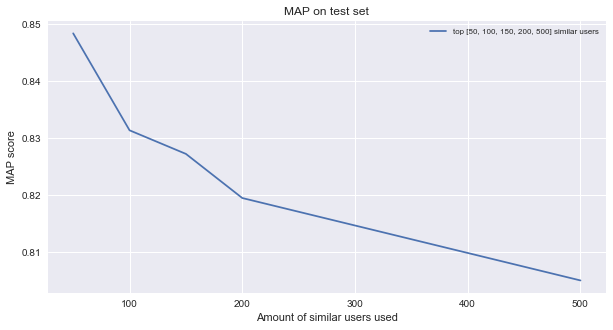

In [120]:
# plt.figure(figsize=(10, 5))
# plt.plot(top, score, label = 'top {} similar users'.format(top))
# plt.legend(loc='upper right', fontsize=8)
# plt.xlabel('Amount of similar users used')
# plt.ylabel('MAP score')
# plt.title("MAP on test set")
# plt.show()

### MAP and Hit Rate after filtering null values

In [173]:
top = [50, 100, 200, 500]
score = []
for t in top:
    result = get_map(test_list, predict_result[t])
    score.append(result)
    print("The MAP of top",t,"simialr users is: ", str(result))

The MAP of top 50 simialr users is:  0.09516947529682114
The MAP of top 100 simialr users is:  0.08677586606418722
The MAP of top 200 simialr users is:  0.0807333596421994
The MAP of top 500 simialr users is:  0.07042603563574346


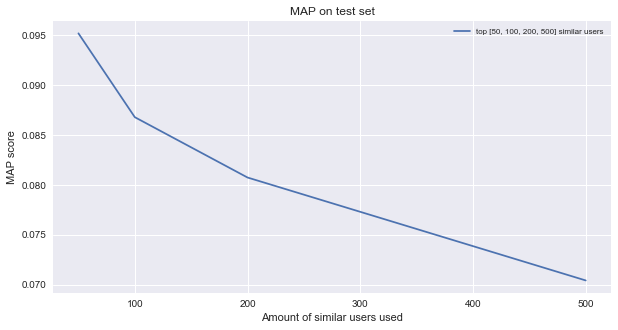

In [174]:
plt.figure(figsize=(10, 5))
plt.plot(top, score, label = 'top {} similar users'.format(top))
plt.legend(loc='upper right', fontsize=8)
plt.xlabel('Amount of similar users used')
plt.ylabel('MAP score')
plt.title("MAP on test set")
plt.show()

In [175]:
top = [50, 100, 200, 500]
hit_rate_update = []
for t in top:
    result = get_hit_rate(test_list, predict_result[t])
    hit_rate_update.append(result)
    print("The Hit Rate of top",t,"simialr users is: ", str(result))

The Hit Rate of top 50 simialr users is:  0.8267326732673267
The Hit Rate of top 100 simialr users is:  0.8366336633663366
The Hit Rate of top 200 simialr users is:  0.8613861386138614
The Hit Rate of top 500 simialr users is:  0.8910891089108911


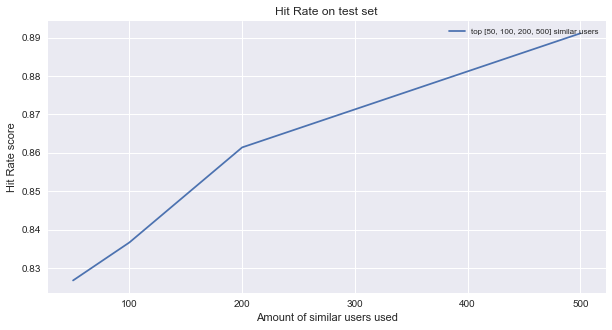

In [177]:
plt.figure(figsize=(10, 5))
plt.plot(top,  hit_rate_update , label = 'top {} similar users'.format(top))
plt.legend(loc='upper right', fontsize=8)
plt.xlabel('Amount of similar users used')
plt.ylabel('Hit Rate score')
plt.title("Hit Rate on test set")
plt.show()


## Referene

Use both Jaccard Similarity and Cosine Similarity

In [ ]:
# from sklearn.metrics import jaccard_similarity_score
# import scipy.spatial as sp

# # 1 - sp.distance.cdist(matrix1, matrix2, 'cosine') #this is the consin similarity of two matrix
# # 1- sp.distance.cdist(matrix1, matrix2, 'jaccard') # this is the jaccard similarity of two matrix



In [ ]:
# TF= .groupby(['ncodpers'], as_index = False, sort = False).count().rename(columns = {‘userId’: ‘tag_count_TF’})[[‘movieId’,’tag’,’tag_count_TF’]]
# Tag_distinct = Tags[[‘tag’,’movieId’]].drop_duplicates()
# DF =Tag_distinct.groupby([‘tag’], as_index = False, sort = False).count().rename(columns = {‘movieId’: ‘tag_count_DF’})[[‘tag’,’tag_count_DF’]]
# a=math.log10(24)
# DF[‘IDF’]=a-np.log10(DF[‘tag_count_DF’])
# TF = pd.merge(TF,DF,on = ‘tag’, how = ‘left’, sort = False)
# TF[‘TF-IDF’]=TF[‘tag_count_TF’]*TF[‘IDF’]

In [ ]:
# df = pd.DataFrame({"A":["foo", "foo", "foo", "bar"], "B":[0,1,1,1], "C":["A","A","B","A"]})
# df.drop_duplicates(subset=['A', 'C'], keep=False).reset_index(drop=True)

In [ ]:
# from sklearn.metrics import jaccard_similarity_score

# print(jaccard_similarity_score(A, B))